# Flow:

1) Read Data from folder
2) Create Graphs & Labels and seperate into test, train & validation (Set1A, Set1B, Set 1C)
4) Train GCN & DCGNN Models on the same (Model1 & Model2)
5) Evaluate the model on Set1A 
6) Obtain Unlabelled graphs
7) Create labels for these unlabelled graphs using trained model (Set2)
8) Combine these trainable datasets as one complete SetC (Set1A, Set1B & Set 2)
9) Train a new model1 with this combined data SetC
10) Evaluate the model1 (trained new) on Set1A to check if performance has improved

In [19]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn.model_selection import KFold
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.utils as ku

import tensorflow as tf

import matplotlib.pyplot as plt

import os
import createGraph
import dataCreate

# Step 1) &  Step 2)

In [73]:
train_folder = 'graphsmallds/'
dtrain_graphs,dtrain_labels = createGraph.readLabeledFolder(train_folder)

print(len(dtrain_graphs))
print(len(dtrain_labels))

#val_folder = ''
#val_graphs,val_labels = createGraph.readLabeledFolder(train_folder)

#unlabeled_folder = ''
#unlabeled_graphs = createGrapg.readUnlabeledFolder(unlabeled_folder)

15
15


In [61]:
print(dtrain_labels)


0     1
1     2
2     3
3     4
4     0
5     1
6     2
7     3
8     4
9     0
10    1
11    2
12    3
13    4
14    0
dtype: category
Categories (5, int64): [0, 1, 2, 3, 4]


# Splitting & Training Data Step 3) & 4)

In [58]:
#Hyper Parameters 
epochs = 200  # maximum number of training epochs
folds = 2 # the number of folds for k-fold cross validation
n_repeats = 5  # the number of repeats for repeated k-fold cross validation

### GCN Module

In [60]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=5, activation="softmax")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc"])

    return model

def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels[train_index], batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels[test_index], batch_size=batch_size
    )

    return train_gen, test_gen

# Convert the dtrain_labels to a numpy array
labels = dtrain_labels.cat.codes.values

# Convert the labels to one-hot encoded vectors
dtrain_labels_gcn = ku.to_categorical(labels)

print(dtrain_labels_gcn)

generator = PaddedGraphGenerator(graphs=dtrain_graphs)

es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

test_accs = []

#Create 10 fold training
stratified_folds = KFold(
    n_splits=folds
).split(dtrain_labels, dtrain_labels_gcn)

for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, dtrain_labels_gcn, batch_size=30
    )

    model_1 = create_graph_classification_model(generator)

    history, acc = train_fold(model_1, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1 out of 10...
Training and evaluating on fold 2 out of 10...


Accuracy over all folds mean: 79.5% and std: 8.0%


Text(0, 0.5, 'Count')

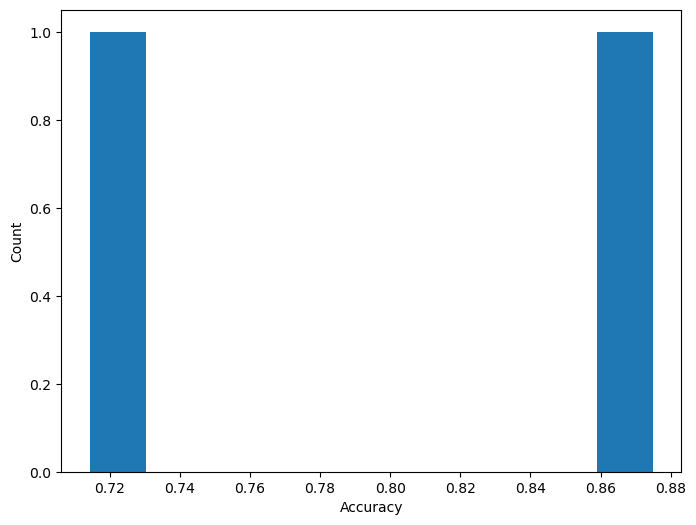

In [62]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

### DGCNN Module

In [67]:
#Defining the DGCNN model

k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=5, activation="softmax")(x_out)

model_2 = Model(inputs=x_inp, outputs=predictions)

model_2.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"],
)

df = pd.DataFrame(dtrain_labels_gcn)
print(df)

#Split the data
train_graphs, test_graphs = model_selection.train_test_split(
    df, train_size=10, test_size=5, stratify=dtrain_labels,)

print(train_graphs.shape)

#Graph generators for split data
gen = PaddedGraphGenerator(graphs=dtrain_graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)
#training the model
history = model_2.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

      0    1    2    3    4
0   0.0  1.0  0.0  0.0  0.0
1   0.0  0.0  1.0  0.0  0.0
2   0.0  0.0  0.0  1.0  0.0
3   0.0  0.0  0.0  0.0  1.0
4   1.0  0.0  0.0  0.0  0.0
5   0.0  1.0  0.0  0.0  0.0
6   0.0  0.0  1.0  0.0  0.0
7   0.0  0.0  0.0  1.0  0.0
8   0.0  0.0  0.0  0.0  1.0
9   1.0  0.0  0.0  0.0  0.0
10  0.0  1.0  0.0  0.0  0.0
11  0.0  0.0  1.0  0.0  0.0
12  0.0  0.0  0.0  1.0  0.0
13  0.0  0.0  0.0  0.0  1.0
14  1.0  0.0  0.0  0.0  0.0
(10, 5)
Epoch 1/200
1/1 [==============================] - 1s 742ms/step - loss: 0.6983 - acc: 0.1000 - val_loss: 0.6821 - val_acc: 0.4000
Epoch 2/200
1/1 [==============================] - 0s 26ms/step - loss: 0.6956 - acc: 0.2000 - val_loss: 0.6578 - val_acc: 0.6000
Epoch 3/200
1/1 [==============================] - 0s 27ms/step - loss: 0.6601 - acc: 0.5000 - val_loss: 0.6369 - val_acc: 0.6000
Epoch 4/200
1/1 [==============================] - 0s 28ms/step - loss: 0.6428 - acc: 0.2000 - val_loss: 0.6128 - val_acc: 0.6000
Epoch 5/200
1/1 [======

1/1 [==============================] - 0s 25ms/step - loss: 0.1393 - acc: 0.9000 - val_loss: 0.1150 - val_acc: 0.8000
Epoch 61/200
1/1 [==============================] - 0s 26ms/step - loss: 0.1848 - acc: 0.7000 - val_loss: 0.1147 - val_acc: 0.8000
Epoch 62/200
1/1 [==============================] - 0s 26ms/step - loss: 0.1572 - acc: 0.7000 - val_loss: 0.1147 - val_acc: 0.8000
Epoch 63/200
1/1 [==============================] - 0s 27ms/step - loss: 0.1351 - acc: 0.8000 - val_loss: 0.1148 - val_acc: 0.8000
Epoch 64/200
1/1 [==============================] - 0s 26ms/step - loss: 0.1627 - acc: 0.7000 - val_loss: 0.1150 - val_acc: 0.8000
Epoch 65/200
1/1 [==============================] - 0s 26ms/step - loss: 0.1826 - acc: 0.7000 - val_loss: 0.1156 - val_acc: 0.8000
Epoch 66/200
1/1 [==============================] - 0s 27ms/step - loss: 0.1132 - acc: 1.0000 - val_loss: 0.1161 - val_acc: 0.8000
Epoch 67/200
1/1 [==============================] - 0s 26ms/step - loss: 0.1738 - acc: 0.7000 - 

1/1 [==============================] - 0s 26ms/step - loss: 0.1142 - acc: 0.9000 - val_loss: 0.1126 - val_acc: 0.8000
Epoch 123/200
1/1 [==============================] - 0s 27ms/step - loss: 0.1217 - acc: 0.7000 - val_loss: 0.1126 - val_acc: 0.8000
Epoch 124/200
1/1 [==============================] - 0s 28ms/step - loss: 0.1322 - acc: 0.8000 - val_loss: 0.1126 - val_acc: 0.8000
Epoch 125/200
1/1 [==============================] - 0s 27ms/step - loss: 0.1010 - acc: 1.0000 - val_loss: 0.1126 - val_acc: 0.8000
Epoch 126/200
1/1 [==============================] - 0s 28ms/step - loss: 0.1329 - acc: 0.8000 - val_loss: 0.1126 - val_acc: 0.8000
Epoch 127/200
1/1 [==============================] - 0s 26ms/step - loss: 0.1211 - acc: 0.9000 - val_loss: 0.1125 - val_acc: 0.8000
Epoch 128/200
1/1 [==============================] - 0s 28ms/step - loss: 0.1462 - acc: 0.6000 - val_loss: 0.1125 - val_acc: 0.8000
Epoch 129/200
1/1 [==============================] - 0s 26ms/step - loss: 0.1388 - acc: 0.

1/1 [==============================] - 0s 25ms/step - loss: 0.0874 - acc: 1.0000 - val_loss: 0.1126 - val_acc: 0.8000
Epoch 185/200
1/1 [==============================] - 0s 28ms/step - loss: 0.1063 - acc: 0.9000 - val_loss: 0.1126 - val_acc: 0.8000
Epoch 186/200
1/1 [==============================] - 0s 27ms/step - loss: 0.1259 - acc: 0.8000 - val_loss: 0.1125 - val_acc: 0.8000
Epoch 187/200
1/1 [==============================] - 0s 27ms/step - loss: 0.1137 - acc: 0.8000 - val_loss: 0.1124 - val_acc: 0.8000
Epoch 188/200
1/1 [==============================] - 0s 28ms/step - loss: 0.1443 - acc: 0.6000 - val_loss: 0.1124 - val_acc: 0.8000
Epoch 189/200
1/1 [==============================] - 0s 27ms/step - loss: 0.0952 - acc: 1.0000 - val_loss: 0.1124 - val_acc: 0.8000
Epoch 190/200
1/1 [==============================] - 0s 28ms/step - loss: 0.1038 - acc: 1.0000 - val_loss: 0.1123 - val_acc: 0.8000
Epoch 191/200
1/1 [==============================] - 0s 27ms/step - loss: 0.1112 - acc: 1.

In [68]:
test_metrics = model_2.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model_2.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

5/5 [==============================] - 0s 1ms/step - loss: 0.1120 - acc: 0.8000

Test Set Metrics:
	loss: 0.1120
	acc: 0.8000


# Evaluating both models on secluded data

In [69]:
##### GCN



# Generating New Training Data using these models

In [70]:
#Choose which model to generate data with
#model_choice = model_2
model_choice = model_1

#generate new labels for unlabeled graphs with model_choice 
new_gs,new_lbls = dataCreate.generateNewData(model_choice, unlabeled_graphs)

#append newly generated data with existing data to create updated dataset
updated_graphs, updated_labels = dataCreate.appendTwoDatasets(dtrain_graphs, dtrain_labels,new_gs,new_lbls)

NameError: name 'unlabeled_graphs' is not defined

In [ ]:
#FOR REUSING CODE FROM ABOVE, WE RENAME THE NEW DATA OBJECTS WITH THE ORIGINAL NAME



#Originally the data sizes are:

print(len(dtrain_graphs))
print(len(dtrain_labels))


#We use the old names to refer to the new data now
dtrain_graphs = updated_graphs
dtrain_labels = updated_labels


#Data of new objects now (Should be different)
print(len(dtrain_graphs))
print(len(dtrain_labels))


# Training on the New Dataset

### Retraining GCN Module

In [9]:
# Convert the dtrain_labels to a numpy array
labels = dtrain_labels.cat.codes.values

# Convert the labels to one-hot encoded vectors
dtrain_labels_gcn = ku.to_categorical(labels)

print(dtrain_labels_gcn)

generator = PaddedGraphGenerator(graphs=dtrain_graphs)

es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

test_accs = []

#Create 10 fold training
stratified_folds = KFold(
    n_splits=folds
).split(dtrain_labels, dtrain_labels_gcn)

for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, dtrain_labels_gcn, batch_size=30
    )

    model_1 = create_graph_classification_model(generator)

    history, acc = train_fold(model_1, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1 out of 10...
Training and evaluating on fold 2 out of 10...
Training and evaluating on fold 3 out of 10...
Training and evaluating on fold 4 out of 10...
Training and evaluating on fold 5 out of 10...
Training and evaluating on fold 6 out of 10...


KeyboardInterrupt: 

### Retraining DCGNN Module

In [ ]:
df = pd.DataFrame(dtrain_labels_gcn)
print(df)

#Split the data
train_graphs, test_graphs = model_selection.train_test_split(
    df, train_size=10, test_size=5, stratify=dtrain_labels,)

print(train_graphs.shape)

#Graph generators for split data
gen = PaddedGraphGenerator(graphs=dtrain_graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)
#training the model
history = model_2.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)